# Frida Playing

In [1]:
import pandas as pd
import numpy as np
from ase import Atoms
from dscribe.descriptors import SOAP, ACSF
import matplotlib.pyplot as plt
import joblib

In [2]:
# Data directory
data_dir = r"C:\Users\s201204.FRIDA\Documents\Materials Design with Machine Learning\KaggleCompetition/"
# Loading the data as pandas DataFrame
test = pd.read_json(data_dir + "test.json")
train = pd.read_json(data_dir + 'train.json')
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [3]:
train['ase_atoms'] = train.atoms

In [4]:
test['ase_atoms'] = test.atoms

In [5]:
# List species and count the max number of atoms
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(len(atom))

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

In [6]:
# Create a SOAP descriptor object
soap = SOAP(
    species= species,
    periodic= True, # Assumed 2D materials are periodic
    r_cut = 20,
    n_max=4,     # Adjust as needed
    l_max=4,
    average = 'outer',
    dtype = 'float32'
    )
    

In [7]:
train['soap_descriptors'] = joblib.load('full_train_soap.pkl')

In [10]:
X = train[['soap_descriptors']]

In [11]:
X

,soap_descriptors
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[1.4350720345969605, -6.097689556563071, 27.81..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
7995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is called 'train' and contains the 'id' column

# Define features (X) and target (y)
X = train[['soap_descriptors']]  # Use the SOAP vectors as features
y = train['hform']  # Use 'hform' as the target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, train['id'], test_size=0.2, random_state=251  
)

In [52]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train['soap_descriptors'].values.tolist())  # Assuming X_train is a pandas DataFrame

# Transform the training and test data
X_train['soap_descriptors_scaled'] = list(scaler.transform(X_train['soap_descriptors'].values.tolist()))
X_test['soap_descriptors_scaled'] = list(scaler.transform(X_test['soap_descriptors'].values.tolist()))

In [53]:
# Transform the actual test data
test['soap_descriptors_scaled'] = list(scaler.transform(test['soap_descriptors'].values.tolist()))

In [9]:
from sklearn.preprocessing import PowerTransformer

# Use transform on y-data, fit for negative values and skewed data.
pt = PowerTransformer(method="yeo-johnson")
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)) 
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)) 

# # Convert back to Series if needed:
# y_train_transformed = pd.Series(y_train_transformed.flatten(), index=y_train.index)
# y_test_transformed = pd.Series(y_test_transformed.flatten(), index=y_test.index)

In [11]:
# Convert to arrays
X_train_gp = np.vstack(X_train['soap_descriptors_scaled'].values)
X_test_gp = np.vstack(X_test['soap_descriptors_scaled'].values)

In [54]:
# Convert actual test data to array
test_gp = np.vstack(test['soap_descriptors_scaled'].values)

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components= 0.99)  # Retain 99% of variance
X_train_pca = pca.fit_transform(X_train_gp)
print("With {} PCA components {var:0.4f}% of the variance is explained".format(pca.n_components_, var = 100*np.sum(pca.explained_variance_ratio_)))
X_test_pca = pca.transform(X_test_gp)

With 1423 PCA components 80.0163% of the variance is explained


In [56]:
# Perform PCA on actual scaled test set
test_gp_pca = pca.transform(test_gp)

In [15]:
X_train_pca.shape

(6400, 1423)

In [57]:
test_pca = test_gp_pca

In [58]:
test_pca.shape

(4000, 1423)

In [22]:
from sklearn.model_selection import train_test_split

# Assuming you have X_train_pca, y_train_transformed

# Sample a subset (e.g., 20%)
X_subset, _, y_subset, _ = train_test_split(
    X_train_pca, y_train_transformed, test_size=0.8, random_state=42
)

# Use X_subset, y_subset for hyperparameter tuning

In [49]:
X_subset.shape

(1280, 1423)

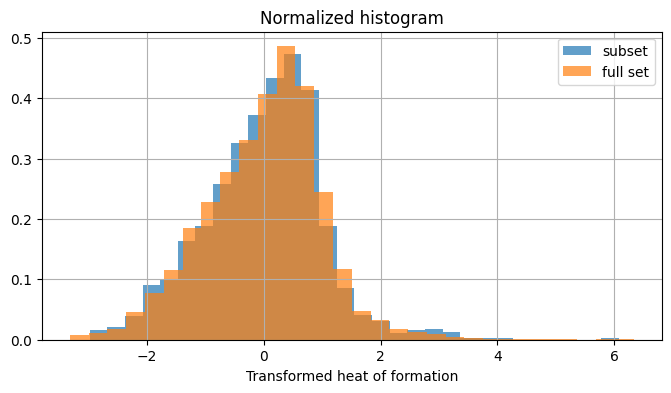

In [18]:
plt.figure(figsize = (8, 4))
plt.hist(y_subset, bins=30, alpha=0.7, density=True, label='subset')
plt.hist(y_train_transformed, bins=30, alpha=0.7, density=True, label='full set')

plt.grid()
plt.title("Normalized histogram")
plt.xlabel("Transformed heat of formation")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Coarse-grained search
param_grid_coarse = {
    'kernel__length_scale': np.logspace(-2, 2, 5),  # Wider range
    'alpha': [1e-2],  # Fewer values
}
grid_search_coarse = GridSearchCV(
    GaussianProcessRegressor(kernel=RBF()), param_grid_coarse, cv=3
)  # Fewer folds
grid_search_coarse.fit(X_subset, y_subset)

# Fine-grained search around best parameters from coarse search
best_params_coarse = grid_search_coarse.best_params_


c:\Users\s201204.FRIDA\.conda\envs\MLDM\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\s201204.FRIDA\.conda\envs\MLDM\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\s201204.FRIDA\.conda\envs\MLDM\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [28]:
best_params_coarse

{'alpha': 0.01, 'kernel__length_scale': np.float64(10.0)}

In [31]:
param_grid_fine = {
    'kernel__length_scale': np.linspace(
        best_params_coarse['kernel__length_scale'] * 0.5,
        best_params_coarse['kernel__length_scale'] * 2,
        5,
    ),  # Narrower range
    'alpha': np.logspace(
        np.log10(best_params_coarse['alpha']) - 1,
        np.log10(best_params_coarse['alpha']) + 1,
        3,
    ),  # More values
}
grid_search_fine = GridSearchCV(
    GaussianProcessRegressor(kernel=RBF()), param_grid_fine, cv=5
)  # More folds
grid_search_fine.fit(X_subset, y_subset)

c:\Users\s201204.FRIDA\.conda\envs\MLDM\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\s201204.FRIDA\.conda\envs\MLDM\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\s201204.FRIDA\.conda\envs\MLDM\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\s201204.FRIDA\.conda\envs\MLDM\Lib\site-packag

GridSearchCV(cv=5,
             estimator=GaussianProcessRegressor(kernel=RBF(length_scale=1)),
             param_grid={'alpha': array([0.001, 0.01 , 0.1  ]),
                         'kernel__length_scale': array([ 5.  ,  8.75, 12.5 , 16.25, 20.  ])})

In [32]:
best_params_fine = grid_search_fine.best_params_

In [38]:
# Create the RBF kernel with the tuned length_scale
kernel = RBF(length_scale=best_params_fine['kernel__length_scale'])

# Train the GP model with the tuned kernel and alpha
gp = GaussianProcessRegressor(kernel=kernel, alpha=best_params_fine['alpha'])
gp.fit(X_train_pca, y_train_transformed)

GaussianProcessRegressor(alpha=np.float64(0.1), kernel=RBF(length_scale=8.75))

In [44]:
import joblib

# Assuming 'gp' is your trained GaussianProcessRegressor object

# Save the model to a file
joblib.dump(gp, 'gp_model.pkl') 

['gp_model.pkl']

In [45]:
# Load the model from the file
loaded_gp = joblib.load('gp_model.pkl')

In [46]:
# Assuming X_new is your new data (scaled and PCA-transformed)
y_pred_new = loaded_gp.predict(X_test_pca)

In [39]:
# Predict on test data
y_pred = gp.predict(X_test_pca)

In [59]:
y_test_pred = gp.predict(test_pca)

In [60]:
# Inverse Yeo Johnson transform on the predicted y_test (as the model predicts Yeo Johnson transformed values)
y_test_pred_original = pt.inverse_transform(y_test_pred.reshape(-1, 1)) 

In [61]:
y_test_pred_original

array([[-1.11954774],
       [-0.32099653],
       [-0.35426714],
       ...,
       [-0.66570766],
       [-0.05597675],
       [-0.89490964]])

In [73]:
id_test_array = test['id'].values

In [77]:
id_test_array[0]

np.int64(8538)

In [82]:
test_id_and_pred = np.column_stack((id_test_array.astype(int), y_test_pred_original))

In [86]:
test_ids = test_id_and_pred[:,0].astype(int)

In [87]:
test_ids

array([ 8538,  9052, 10503, ...,  3741,  6725, 12179])

In [88]:
test_hform = test_id_and_pred[:,1]

In [89]:
test_hform

array([-1.11954774, -0.32099653, -0.35426714, ..., -0.66570766,
       -0.05597675, -0.89490964])

In [90]:
# Stack the arrays horizontally
combined_data = np.column_stack((test_ids, test_hform))
# Save to CSV file with header
np.savetxt('kaggle_submission_1.csv', combined_data, delimiter=',', header='test_ids,test_hform', comments='')

In [91]:
import csv

# Assuming you have test_ids and test_hform as NumPy arrays

# Combine the arrays into a list of rows
data = [[id, hform] for id, hform in zip(test_ids, test_hform)]

# Write the data to a CSV file
with open('kaggle_submission_1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['test_ids', 'test_hform'])  # Write header row
    writer.writerows(data)  # Write data rows

In [40]:
# 'pt' is the PowerTransformer object fitted earlier
y_pred_original = pt.inverse_transform(y_pred.reshape(-1, 1))  

In [41]:
from sklearn.metrics import root_mean_squared_error as rmse

In [42]:
rmse(y_test, y_pred_original)

np.float64(0.40342828308357337)

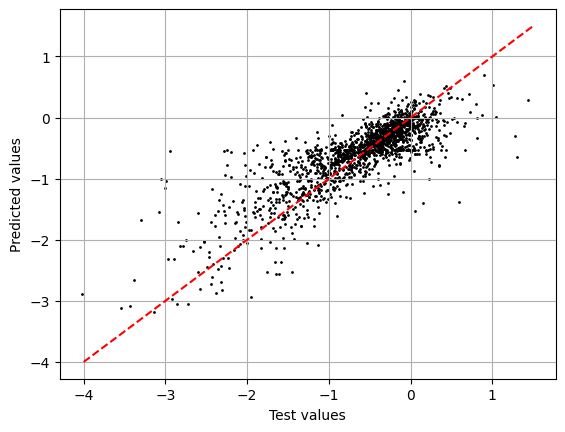

In [43]:
plt.figure()
plt.scatter(y_test, y_pred_original, s =1, color = 'black', )
plt.xlabel('Test values')
plt.ylabel('Predicted values')
plt.grid()
xg = np.linspace(-4,1.5, 2)
plt.plot(xg,xg, color = 'red', linestyle = 'dashed')